In [46]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats._axis_nan_policy import SmallSampleWarning

In [47]:
# supress Pandas warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SmallSampleWarning)

In [48]:
# Transform Google Drive URL to direct download link
url = "https://drive.google.com/file/d/1ubNdFLbIOLQBBXbkbd3C0IZ1VcNmMKsz/view"
url = "https://drive.google.com/uc?id=" + url.split('/')[-2]

dataset = pd.read_csv(url)

In [49]:
# extract and add next events and next timestamps
dataset = dataset.sort_values(by=['timestamp'])
dataset["next_event"] = dataset.groupby("user_id")["event"].shift(-1)
dataset["next_timestamp"] = dataset.groupby("user_id")["timestamp"].shift(-1)

# add duration
dataset["duration"] = dataset["next_timestamp"] - dataset["timestamp"]

# clean dataset
dataset = dataset.dropna(subset=["next_event"])
dataset = dataset.drop(dataset[(dataset["event"] == dataset["next_event"]) | (dataset["event"] == "closed")].index)

twelve_hours_in_ms = 1000 * 3600 * 12

# create auto and manual arrays
auto = dataset[(dataset["open_type"] == "auto") & (dataset["duration"] < twelve_hours_in_ms)]["duration"].values
manual = dataset[(dataset["open_type"] == "manual") & (dataset["duration"] < twelve_hours_in_ms)]["duration"].values

stats.describe(auto), stats.describe(manual)

(DescribeResult(nobs=np.int64(957), minmax=(np.float64(154.0), np.float64(40964418.0)), mean=np.float64(1670930.4273772205), variance=np.float64(22569145008922.65), skewness=np.float64(4.863940115721943), kurtosis=np.float64(26.78676316625833)),
 DescribeResult(nobs=np.int64(617), minmax=(np.float64(15.0), np.float64(37714120.0)), mean=np.float64(630986.0113452188), variance=np.float64(9059907508696.697), skewness=np.float64(8.149677488744631), kurtosis=np.float64(76.6564845172178)))

In [50]:
# Let's use rule of thumb to get rid of outliers
auto_q3 = np.percentile(auto, 75)
auto_q1 = np.percentile(auto, 25)
auto_iqr = np.percentile(auto, 75) - np.percentile(auto, 25)
auto_thumbed = auto[(auto < (auto_q3 + 1.5 * auto_iqr)) & (auto > (auto_q1 - 1.5 * auto_iqr))]

manual_q3 = np.percentile(manual, 75)
manual_q1 = np.percentile(manual, 25)
manual_iqr = np.percentile(manual, 75) - np.percentile(manual, 25)
manual_thumbed = manual[(manual < (manual_q3 + 1.5 * manual_iqr)) & (manual > (manual_q1 - 1.5 * manual_iqr))]

stats.describe(auto_thumbed), stats.describe(manual_thumbed)

(DescribeResult(nobs=np.int64(823), minmax=(np.float64(154.0), np.float64(2211071.0)), mean=np.float64(337083.0340218712), variance=np.float64(241680818167.42953), skewness=np.float64(1.9016381164809912), kurtosis=np.float64(2.837604365442594)),
 DescribeResult(nobs=np.int64(514), minmax=(np.float64(15.0), np.float64(316102.0)), mean=np.float64(36210.198443579764), variance=np.float64(4142243187.8318877), skewness=np.float64(2.4891395626046795), kurtosis=np.float64(5.943462017928317)))

In [51]:
print(stats.ks_2samp(auto, manual))
print(stats.ks_2samp(auto_thumbed, manual_thumbed))
print(stats.mannwhitneyu(auto, manual))
print(stats.mannwhitneyu(auto_thumbed, manual_thumbed))

KstestResult(statistic=np.float64(0.3896648257571524), pvalue=np.float64(2.2674983415213772e-51), statistic_location=np.float64(16103.0), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.47387369924022865), pvalue=np.float64(7.512950160235488e-65), statistic_location=np.float64(16103.0), statistic_sign=np.int8(-1))
MannwhitneyuResult(statistic=np.float64(438570.5), pvalue=np.float64(1.3264551870505135e-59))
MannwhitneyuResult(statistic=np.float64(347740.5), pvalue=np.float64(1.460472228795756e-87))


They're definitely from different distributions (p-value << 0.05)... Let's do Cliff's Delta test with the level of confidence of 0.95

In [52]:
cliffs_delta = (2 * stats.mannwhitneyu(auto_thumbed, manual_thumbed).statistic) / (len(auto_thumbed) * len(manual_thumbed)) - 1

# Bootstrap to get confidence interval. Analytically it's hard to get it, since indicator variables are not independent...

def cliffs_delta_func(x, y):
    u_stat = stats.mannwhitneyu(x, y, alternative="two-sided").statistic
    return (2 * u_stat) / (len(x) * len(y)) - 1

bootstrap_result = stats.bootstrap(
    data=(auto_thumbed, manual_thumbed),
    statistic=cliffs_delta_func,
    paired=False,
    confidence_level=0.95,
    n_resamples=1000
)

bootstrap_result.confidence_interval

ConfidenceInterval(low=np.float64(0.5977782982111237), high=np.float64(0.6874037418771669))

This clearly shows that automatically opened window stays open for a longer period of time. Let's build the difference of means with a 95% confidence level and then finally analyze the data inside one user.

In [53]:
alpha = 0.05
mean = auto_thumbed.mean() - manual_thumbed.mean()
s = np.sqrt(auto_thumbed.var()/len(auto_thumbed) + manual_thumbed.var()/len(manual_thumbed))
mean - s * stats.norm.ppf(1 - alpha/2), mean + s * stats.norm.ppf(1 - alpha/2)

(np.float64(266849.26696424565), np.float64(334896.40419233724))

In [54]:
# Now let's analyze data inside one user

by_user_info = dataset.groupby(by=["user_id", "open_type"])
by_user_info = by_user_info.agg({
    "duration": [np.mean, stats.sem],
    "event": "count"
}).reset_index()

by_user_info.drop(by_user_info[by_user_info[("event", "count")] < 10].index, inplace=True)
has_both_types = by_user_info.groupby('user_id')['open_type'].transform('nunique') >= 2

by_user_info = by_user_info[has_both_types].reset_index(drop=True)

by_user_info

user_id open_type      duration               event
                              mean           sem count
0       12      auto  6.021673e+06  2.518824e+06    52
1       12    manual  1.605658e+06  7.687617e+05    27
2       14      auto  5.659337e+06  4.966767e+06    12
3       14    manual  2.602650e+04  1.075561e+04    14
4       22      auto  4.525724e+05  1.242862e+05    46
5       22    manual  2.385808e+05  1.894452e+05    14
6       25      auto  8.018304e+06  2.800372e+06    41
7       25    manual  4.080154e+06  1.649146e+06    25
8       28      auto  9.616557e+06  4.185492e+06    34
9       28    manual  4.922195e+05  4.220328e+05    26
10      37      auto  1.184910e+06  4.934090e+05    11
11      37    manual  4.632591e+05  2.558393e+05    18
12      45      auto  4.091338e+04  2.211300e+04    16
13      45    manual  1.251885e+06  1.095398e+06    11

If we consider the data inside each user, which we found "reasonable" (at least 10 events of each type), we can see that across 14 users, only 1 kept the toolwindow opened manually longer than automatically on average

In [55]:
# This is definitely not something random:
p = stats.binomtest(13, 14, p=0.5, alternative='two-sided')

print("P-value for binom test", p.pvalue)

P-value for binom test 0.0018310546875


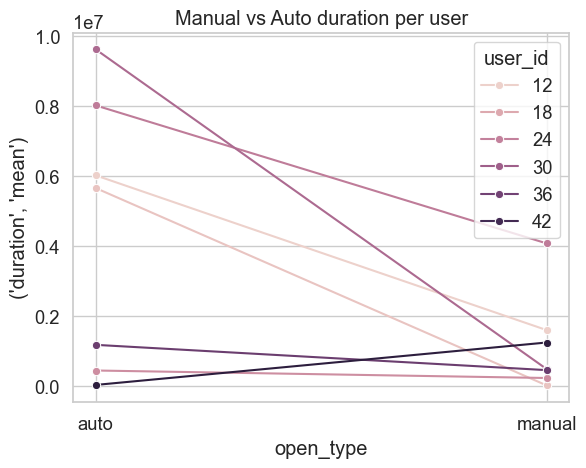

In [58]:
sns.lineplot(x='open_type', y=('duration','mean'), hue='user_id', data=by_user_info, marker='o')
plt.title('Manual vs Auto duration per user')
plt.savefig("manual_vs_auto_per_user.png")
plt.show()

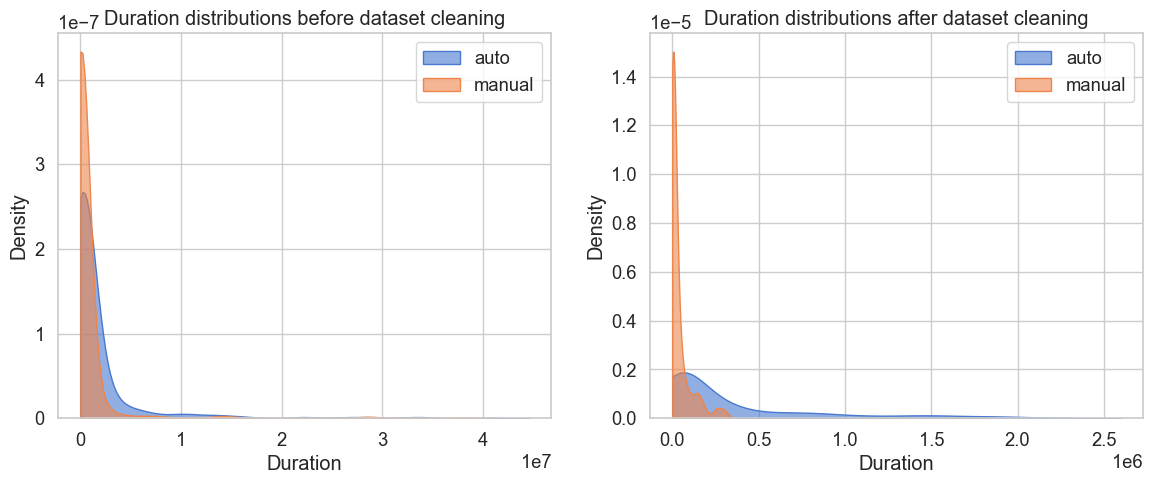

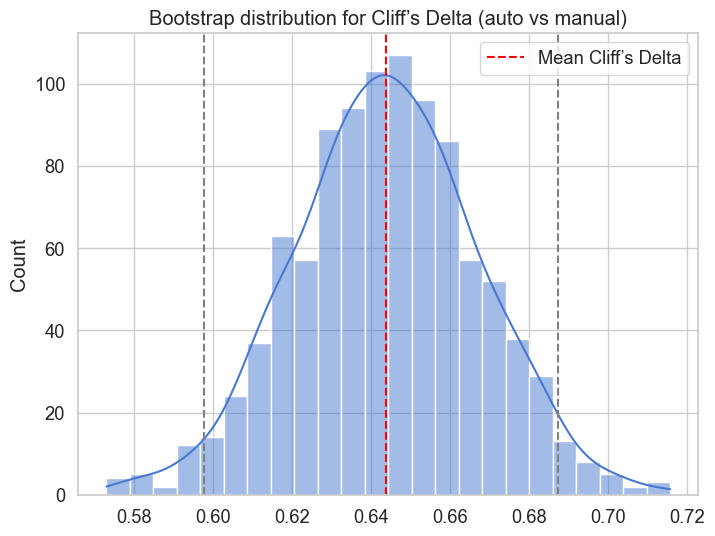

In [59]:
# Initial data distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(auto, fill=True, ax=ax[0], label='auto', alpha=0.6, clip=(0, None))
sns.kdeplot(manual, fill=True, ax=ax[0], label='manual', alpha=0.6, clip=(0, None))
ax[0].set_title("Duration distributions before dataset cleaning")
ax[0].set_xlabel("Duration")
ax[0].legend()

sns.kdeplot(auto_thumbed, fill=True, ax=ax[1], label='auto', alpha=0.6, clip=(0, None))
sns.kdeplot(manual_thumbed, fill=True, ax=ax[1], label='manual', alpha=0.6, clip=(0, None))
ax[1].set_title("Duration distributions after dataset cleaning")
ax[1].set_xlabel("Duration")
ax[1].legend()
plt.savefig("manual_vs_auto.png")
plt.show()

# Cliff's delta bootstrap distribution
plt.figure(figsize=(8, 6))
sns.histplot(bootstrap_result.bootstrap_distribution, kde=True)
plt.axvline(bootstrap_result.bootstrap_distribution.mean(), color='red', linestyle='--', label='Mean Cliff’s Delta')
plt.axvline(bootstrap_result.confidence_interval.low, color='gray', linestyle='--')
plt.axvline(bootstrap_result.confidence_interval.high, color='gray', linestyle='--')
plt.title("Bootstrap distribution for Cliff’s Delta (auto vs manual)")
plt.legend()
plt.savefig("bootstrap_distribution.png")
plt.show()
